In [1]:
import pandas as pd
import json
import ast
import pickle
import geopandas as gpd
from functools import reduce
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import os
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
import statsmodels.api as sms
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/liqingchun/opt/anaconda3/envs/Ida/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
core = pd.read_csv("./Louisiana state core/LA.csv.gz")

In [3]:
new_08_02 = pd.read_csv('./weekly_data/08_02/LA_08_02.csv.gz')

new_08_09 = pd.read_csv('./weekly_data/08_09/LA_08_09.csv.gz')

new_08_16 = pd.read_csv('./weekly_data/08_16/LA_08_16.csv.gz')

new_08_23 = pd.read_csv('./weekly_data/08_23/LA_08_23.csv.gz')

## get number of residing devices in cbgs

In [4]:
de_0802 = pd.read_csv('./weekly_data/08_02/safegraph_home_panel_summary.csv.gz')

de_0802 = de_0802[de_0802.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0802 = de_0802.rename(columns={'census_block_group':'GEOID'})

de_0802.GEOID = de_0802.GEOID.astype(int)

In [5]:
de_0809 = pd.read_csv('./weekly_data/08_09/safegraph_home_panel_summary.csv.gz')

de_0809 = de_0809[de_0809.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0809 = de_0809.rename(columns={'census_block_group':'GEOID'})

de_0809.GEOID = de_0809.GEOID.astype(int)

In [6]:
de_0816 = pd.read_csv('./weekly_data/08_16/safegraph_home_panel_summary.csv.gz')

de_0816 = de_0816[de_0816.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0816 = de_0816.rename(columns={'census_block_group':'GEOID'})

de_0816.GEOID = de_0816.GEOID.astype(int)

In [7]:
de_0823 = pd.read_csv('./weekly_data/08_23/safegraph_home_panel_summary.csv.gz')

de_0823 = de_0823[de_0823.region=='la'][['census_block_group', 'number_devices_residing']].reset_index(drop=True)

de_0823 = de_0823.rename(columns={'census_block_group':'GEOID'})

de_0823.GEOID = de_0823.GEOID.astype(int)

In [8]:
new_08_02 = new_08_02.merge(core, how='left', on='placekey')
grocery_new_08_02 = new_08_02[new_08_02.sg_c__top_category == 'Grocery Stores']
grocery_new_08_02 = grocery_new_08_02.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [9]:
new_08_09 = new_08_09.merge(core, how='left', on='placekey')
grocery_new_08_09 = new_08_09[new_08_09.sg_c__top_category == 'Grocery Stores']
grocery_new_08_09 = grocery_new_08_09.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [10]:
new_08_16 = new_08_16.merge(core, how='left', on='placekey')
grocery_new_08_16 = new_08_16[new_08_16.sg_c__top_category == 'Grocery Stores']
grocery_new_08_16 = grocery_new_08_16.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [11]:
new_08_23 = new_08_23.merge(core, how='left', on='placekey')
grocery_new_08_23 = new_08_23[new_08_23.sg_c__top_category == 'Grocery Stores']
grocery_new_08_23 = grocery_new_08_23.rename(columns={"sg_wp__visitor_home_cbgs": "visitor_home_cbgs"})

In [12]:
def Cbg_visit(dataframe):
    cbg_visit = {}
    for each in dataframe.visitor_home_cbgs:
        poi_visit = ast.literal_eval(each)
        for key, value in poi_visit.items():
            if key not in cbg_visit.keys():
                cbg_visit[key] = value
            elif key in cbg_visit.keys():
                cbg_visit[key] += value
    return cbg_visit

# Cbg geoinformation

In [13]:
cbg_shp = gpd.read_file("./tl_2019_22_bg/tl_2019_22_bg.shp")
cbg_shp['GEOID']=cbg_shp['GEOID'].astype(int)

# Demographic information (all cbgs in US)

In [14]:
cbg_pop = pd.read_csv('./cbg_2019/data/cbg_b01.csv')
cbg_pop = cbg_pop[['B01001e1', 'census_block_group']]

cbg_house = pd.read_csv('./cbg_2019/data/cbg_b11.csv')
cbg_house = cbg_house[['B11005e1', 'census_block_group']]


cbg_race = pd.read_csv('./cbg_2019/data/cbg_b02.csv')

cbg_race_white = cbg_race[['B02001e2', 'census_block_group']]
cbg_race_black = cbg_race[['B02001e3', 'census_block_group']]

cbg_income = pd.read_csv('./cbg_2019/data/cbg_b19.csv')
cbg_income_median = cbg_income[['B19013e1', 'census_block_group']]


data_frames = [cbg_pop, cbg_race_white, cbg_race_black, cbg_income_median, cbg_house]

cbg_data = reduce(lambda  left,right: pd.merge(left,right,on=['census_block_group'],
                                            how='outer'), data_frames)

cbg_data.rename(columns={"census_block_group": "GEOID", 'B01001e1':'Population', 'B02001e2':'White',
                        'B02001e3':'Black', 'B19013e1':'income_median', 'B11005e1':'households'}, inplace=True)

# Return dataframe

In [146]:
def Cor_analysis(dataframe, de_dataframe):
    visit = Cbg_visit(dataframe) #calculate cbg visits to all pois in that categories and visits to 
    #significant POIs
    visit_list = [] #visits to all pois in the category
    for each in cbg_shp['GEOID']:
        if str(each) in visit.keys():
            visit_list.append(visit[str(each)])
        else:
            visit_list.append(0)
            

    #construct new dataframe 
    df_function = cbg_shp.copy(deep=True)
    df_function['visits'] = visit_list
    
    df_temp = df_function[['GEOID', 'visits']]
    
    #concate with social demographic dataframe
    cbg_data_la = pd.merge(df_temp, cbg_data, how='left', on=['GEOID'])
    
    ##concate with device residing dataframe
    cbg_data_la = cbg_data_la.merge(de_dataframe, how='left', on=['GEOID'])
    
    
    columns = list(cbg_data_la.columns) 
    remove_list = ['GEOID', 'visits', 'number_devices_residing']
    subset = [element for element in columns if element not in remove_list]
    #print(subset)
    
    cbg_data_la = cbg_data_la.dropna(how='any', subset=subset)
    
    
    return cbg_data_la

In [147]:
df_08_23 = Cor_analysis(grocery_new_08_23, de_0823)

In [148]:
df_08_02 = Cor_analysis(grocery_new_08_02, de_0802)
df_08_09 = Cor_analysis(grocery_new_08_09, de_0809)
df_08_16 = Cor_analysis(grocery_new_08_16, de_0816)

In [149]:
visits_average = (df_08_02.visits + df_08_09.visits+ df_08_16.visits)/3

In [150]:
resident_average = (df_08_02.number_devices_residing + 
                    df_08_09.number_devices_residing+ 
                    df_08_16.number_devices_residing)/3

In [151]:
df_before = df_08_02.copy(deep=True)

In [152]:
df_before.visits = visits_average
df_before.number_devices_residing = resident_average

In [153]:
df_before

,GEOID,visits,Population,White,Black,income_median,households,number_devices_residing
0,221090012021,35.666667,950,858,9,52361.0,305,77.000000
1,221090012023,52.666667,950,822,0,49904.0,346,88.666667
2,221030413003,21.666667,1568,1420,148,72083.0,769,83.000000
3,221030407011,113.666667,2946,2715,109,53894.0,1176,238.333333
4,221030411011,52.666667,3721,2987,642,71655.0,1251,212.333333
...,...,...,...,...,...,...,...,...
3466,220070506003,84.000000,1937,1727,62,23867.0,630,130.666667
3467,220070501002,64.666667,1877,916,943,41375.0,770,98.333333
3468,220070503001,77.333333,1406,765,641,59848.0,554,79.666667
3469,220070506002,17.666667,1177,974,192,51552.0,474,59.333333


In [154]:
df_08_23

,GEOID,visits,Population,White,Black,income_median,households,number_devices_residing
0,221090012021,47,950,858,9,52361.0,305,89.0
1,221090012023,52,950,822,0,49904.0,346,94.0
2,221030413003,24,1568,1420,148,72083.0,769,90.0
3,221030407011,134,2946,2715,109,53894.0,1176,247.0
4,221030411011,66,3721,2987,642,71655.0,1251,216.0
...,...,...,...,...,...,...,...,...
3466,220070506003,85,1937,1727,62,23867.0,630,143.0
3467,220070501002,69,1877,916,943,41375.0,770,100.0
3468,220070503001,55,1406,765,641,59848.0,554,82.0
3469,220070506002,42,1177,974,192,51552.0,474,59.0


In [155]:
df_ratio = df_08_23.rename(columns = {'visits':'visits_after'})

df_ratio = df_ratio.merge(df_before[['GEOID', 'visits']], how='left', on='GEOID')
df_ratio['ratio'] = df_ratio.visits_after/df_ratio.visits

In [156]:
df_ratio

,GEOID,visits_after,Population,White,Black,income_median,households,number_devices_residing,visits,ratio
0,221090012021,47,950,858,9,52361.0,305,89.0,35.666667,1.317757
1,221090012023,52,950,822,0,49904.0,346,94.0,52.666667,0.987342
2,221030413003,24,1568,1420,148,72083.0,769,90.0,21.666667,1.107692
3,221030407011,134,2946,2715,109,53894.0,1176,247.0,113.666667,1.178886
4,221030411011,66,3721,2987,642,71655.0,1251,216.0,52.666667,1.253165
...,...,...,...,...,...,...,...,...,...,...
3216,220070506003,85,1937,1727,62,23867.0,630,143.0,84.000000,1.011905
3217,220070501002,69,1877,916,943,41375.0,770,100.0,64.666667,1.067010
3218,220070503001,55,1406,765,641,59848.0,554,82.0,77.333333,0.711207
3219,220070506002,42,1177,974,192,51552.0,474,59.0,17.666667,2.377358


In [157]:
df_diff = df_before.rename(columns={'visits':'visitors_before'})

df_temp = df_08_23[['GEOID', 'visits']]
df_temp = df_temp.rename(columns={'visits':'visitors_after'})

df_diff = df_diff.merge(df_temp, on='GEOID')

df_diff['visitor_diff'] = df_diff.visitors_after - df_diff.visitors_before

In [158]:
df_diff

,GEOID,visitors_before,Population,White,Black,income_median,households,number_devices_residing,visitors_after,visitor_diff
0,221090012021,35.666667,950,858,9,52361.0,305,77.000000,47,11.333333
1,221090012023,52.666667,950,822,0,49904.0,346,88.666667,52,-0.666667
2,221030413003,21.666667,1568,1420,148,72083.0,769,83.000000,24,2.333333
3,221030407011,113.666667,2946,2715,109,53894.0,1176,238.333333,134,20.333333
4,221030411011,52.666667,3721,2987,642,71655.0,1251,212.333333,66,13.333333
...,...,...,...,...,...,...,...,...,...,...
3216,220070506003,84.000000,1937,1727,62,23867.0,630,130.666667,85,1.000000
3217,220070501002,64.666667,1877,916,943,41375.0,770,98.333333,69,4.333333
3218,220070503001,77.333333,1406,765,641,59848.0,554,79.666667,55,-22.333333
3219,220070506002,17.666667,1177,974,192,51552.0,474,59.333333,42,24.333333


# calculate some variables

In [159]:
df_08_23['white_per_population'] = df_08_23['White']/df_08_23['Population']
df_08_23['visits_per_population'] = (1000*df_08_23['visits']/df_08_23['Population'])
df_08_23['visits_per_household'] = (1000*df_08_23['visits']/df_08_23['households'])

In [160]:
df_before['white_per_population'] = df_before['White']/df_before['Population']
df_before['visits_per_population'] = (1000*df_before['visits']/df_before['Population'])
df_before['visits_per_household'] = (1000*df_before['visits']/df_before['households'])

In [161]:
df_diff['white_per_population'] = df_diff['White']/df_diff['Population']
df_diff['visits_per_population'] = (1000*df_diff['visitor_diff']/df_diff['Population'])
df_diff['visits_per_household'] = (1000*df_diff['visitor_diff']/df_diff['households'])

In [162]:
df_ratio['white_per_population'] = df_ratio['White']/df_ratio['Population']

# remove outlier

In [163]:
index = df_before[df_before.Population < df_before.number_devices_residing].index

df_before = df_before.drop(index)

len(df_before)

3220

In [164]:
index = df_08_23[df_08_23.Population < df_08_23.number_devices_residing].index

df_08_23 = df_08_23.drop(index)

len(df_08_23)

3220

In [165]:
index = df_ratio[df_ratio.Population < df_ratio.number_devices_residing].index

df_ratio = df_ratio.drop(index)

len(df_ratio)

3220

In [166]:
temp = df_08_23[(df_08_23.households >= 100) & (df_08_23.households < 200)]

df_1 = temp[temp.number_devices_residing >= ((temp.households-100)*0.13 + 46)]

temp1 = df_08_23[(df_08_23.households >= 200) & (df_08_23.households < 300)]

df_2 = temp1[temp1.number_devices_residing >= ((temp1.households-200)*0.06 + 59)]

temp2 = df_08_23[(df_08_23.households >= 300) & (df_08_23.households < 400)]

df_3 = temp2[temp2.number_devices_residing >= ((temp2.households-300)*0.04 + 65)]

temp3 = df_08_23[(df_08_23.households >= 400) & (df_08_23.households < 500)]

df_4 = temp3[temp3.number_devices_residing >= ((temp3.households-400)*0.03 + 69)]

temp4 = df_08_23[(df_08_23.households >= 500) & (df_08_23.households < 600)]

df_5 = temp4[temp4.number_devices_residing >= ((temp4.households-500)*0.01 + 72)]

temp5 = df_08_23[(df_08_23.households >= 600) & (df_08_23.households < 700)]

df_6 = temp5[temp5.number_devices_residing >= ((temp5.households-600)*0.02 + 73)]

temp6 = df_08_23[(df_08_23.households >= 700) & (df_08_23.households < 800)]

df_7 = temp6[temp6.number_devices_residing >= ((temp6.households-700)*0.01 + 75)]

temp7 = df_08_23[(df_08_23.households >= 800) & (df_08_23.households < 900)]

df_8 = temp7[temp7.number_devices_residing >= 76]

temp8 = df_08_23[(df_08_23.households >= 900) & (df_08_23.households < 1000)]

df_9 = temp8[temp8.number_devices_residing >= 76]

temp9 = df_08_23[(df_08_23.households >= 1000) & (df_08_23.households < 1500)]

df_10 = temp9[temp9.number_devices_residing >= ((temp9.households-1000)*0.004 + 77)]

temp10 = df_08_23[(df_08_23.households >= 1500) & (df_08_23.households < 2000)]

df_11 = temp10[temp10.number_devices_residing >= ((temp10.households-1500)*0.008 + 79)]

temp11 = df_08_23[(df_08_23.households >= 2000) & (df_08_23.households < 4000)]

df_12 = temp11[temp11.number_devices_residing >= 83]

df_08_23 = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8,
                       df_9, df_10, df_11, df_12], 
            axis=0)

len(df_08_23)

1530

In [167]:
df_before = df_before[df_before.GEOID.isin(df_08_23.GEOID)]
len(df_before)

1530

In [168]:
df_ratio = df_ratio[df_ratio.GEOID.isin(df_08_23.GEOID)]

len(df_ratio)

1530

In [1]:
from scipy import stats
import scikit_posthocs as sp
def kw_test(dataframe, column, print_statistics=True):
    
    test_variable = 'visits_per_household'
    quantile1 = dataframe[column].quantile(0.25)
    quantile2 = dataframe[column].quantile(0.5)
    quantile3 = dataframe[column].quantile(0.75)
    quantile4 = dataframe[column].quantile(1)
    
    group1 = dataframe[(dataframe[column] >= 0) & (dataframe[column] < quantile1)]
    group2 = dataframe[(dataframe[column] >= quantile1) & (dataframe[column] < quantile2)]
    group3 = dataframe[(dataframe[column] >= quantile2) & (dataframe[column] < quantile3)]
    group4 = dataframe[(dataframe[column] >= quantile3) & (dataframe[column] <= quantile4)]
    
    table = [['N', 'Min', 'Max', 'Median', 'Variance'], 
             ['Group 1', len(group1), group1[column].min(), group1[column].max(), group1[column].median(), group1[column].var()],
             ['Group 2', len(group2), group2[column].min(), group2[column].max(), group2[column].median(), group2[column].var()],
             ['Group 3', len(group3), group3[column].min(), group3[column].max(), group3[column].median(), group3[column].var()],
             ['Group 4', len(group4), group4[column].min(), group4[column].max(), group4[column].median(), group4[column].var()]]
    
    print('check the number of each group samples:')
    print(len(group1), len(group2), len(group3), len(group4))
    
    print('\n')
    
     #remove outlier
    
    test1 = group1[test_variable]
    #test1 = test1[test1.between(test1.quantile(.01), test1.quantile(.99))]
    
    test2 = group2[test_variable]
    #test2 = test2[test2.between(test2.quantile(.01), test2.quantile(.99))]
    
    test3 = group3[test_variable]
    #test3 = test3[test3.between(test3.quantile(.01), test3.quantile(.99))]
    
    test4 = group4[test_variable]
    #test4 = test4[test4.between(test4.quantile(.01), test4.quantile(.99))]
    
    
    print('median of each quantile')
    print(round(test1.median(),3), 
          round(test2.median(),3), 
          round(test3.median(),3), 
          round(test4.median(),3))
    
    print('\n')
    
    print('Results of KW test')
    kw = stats.kruskal(test1, test2, test3, test4)
    print(kw)
    
    print('\n')
    
    print('Results of Dunn test')
    dunn = sp.posthoc_dunn([test1,test2,test3,test4],
                           p_adjust = 'fdr_bh')
    print(dunn)
    
    print('\n')
    
    print('Boxplots of ratios of four groups')
    df_temp =  pd.concat(
        [
            test1.reset_index(drop=True).rename('<P25'),
            test2.reset_index(drop=True).rename('P25~50'),
            test3.reset_index(drop=True).rename('P50~75'),
            test4.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)
    
    
    import matplotlib_inline.backend_inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
    
    fig, ax = plt.subplots(figsize = (5,5))
    plt.style.use('default')
    
    color = {
    "boxes": "Black",
    "whiskers": "Black",
    "medians": "Black",
    "caps": "Black"}
    
    meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
    df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)
    
    plt.xlabel(column.replace('_', ' ') + ' groups', weight='bold')
    plt.ylabel("Residents per 1k households \n POI: Grocery stores", weight='bold')
    plt.show()
    
    if print_statistics:
        print('Basic statistics of each group')
        print(tabulate(table, headers='firstrow', tablefmt='pretty'))

        print('Boxplots of four groups')
        df_temp1 =  pd.concat(
            [
                group1[column].reset_index(drop=True).rename('<P25'),
                group2[column].reset_index(drop=True).rename('P25~50'),
                group3[column].reset_index(drop=True).rename('P50~75'),
                group4[column].reset_index(drop=True).rename('P75~100'),
            ], 
            axis=1)
        fig, ax = plt.subplots(figsize = (5,5))
        plt.style.use('default')

        color = {
        "boxes": "Black",
        "whiskers": "Black",
        "medians": "Red",
        "caps": "Black"}

        df_temp1.boxplot(showfliers=False, grid=False, color=color)

        plt.ylabel(column.replace('_', ' '), weight='bold')
        plt.show()
    
    
    return None
    

check the number of each group samples:
383 382 382 383


median of each quantile
69.395 82.678 77.949 84.35


Results of KW test
KruskalResult(statistic=25.792936700355774, pvalue=1.0538479354658196e-05)


Results of Dunn test
          1         2         3         4
1  1.000000  0.000066  0.000407  0.000066
2  0.000066  1.000000  0.719790  0.900129
3  0.000407  0.719790  1.000000  0.719790
4  0.000066  0.900129  0.719790  1.000000


Boxplots of ratios of four groups


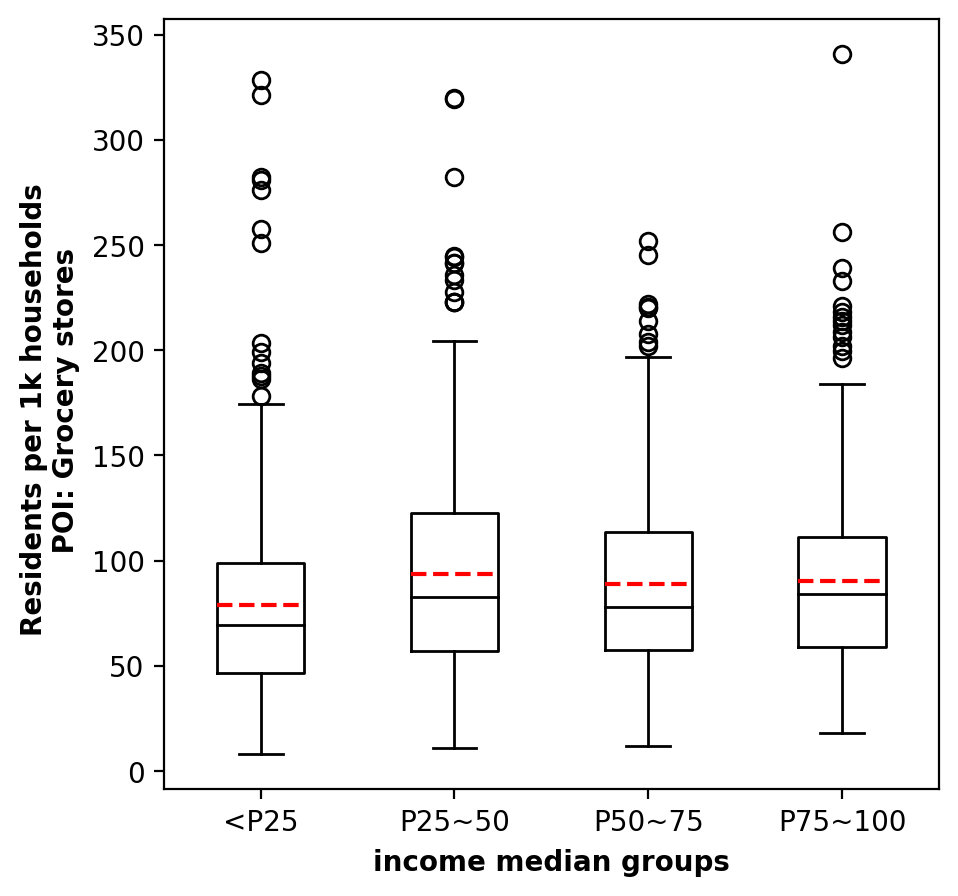

Basic statistics of each group
+---------+-----+---------+----------+---------+--------------------+
|         |  N  |   Min   |   Max    | Median  |      Variance      |
+---------+-----+---------+----------+---------+--------------------+
| Group 1 | 383 | 9910.0  | 40750.0  | 31910.0 | 46757931.65857859  |
| Group 2 | 382 | 40805.0 | 54464.0  | 47290.0 | 16894451.955201935 |
| Group 3 | 382 | 54554.0 | 70893.0  | 62040.5 | 21207877.27524014  |
| Group 4 | 383 | 70962.0 | 170278.0 | 86667.0 | 412770874.3385507  |
+---------+-----+---------+----------+---------+--------------------+
Boxplots of four groups


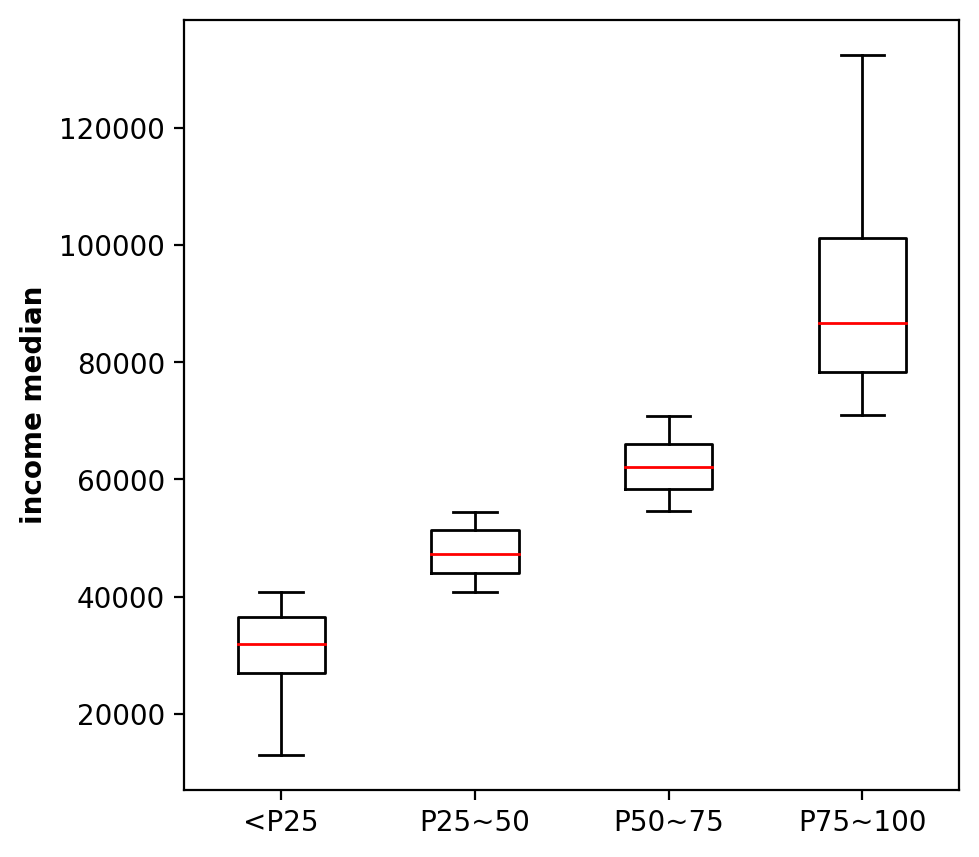

In [170]:
kw_test(df_before, 'income_median',True)

check the number of each group samples:
383 382 382 383


median of each quantile
76.503 85.883 86.165 87.0


Results of KW test
KruskalResult(statistic=21.8130774752111, pvalue=7.134135030811869e-05)


Results of Dunn test
          1         2         3         4
1  1.000000  0.000471  0.000471  0.000363
2  0.000471  1.000000  0.970410  0.923151
3  0.000471  0.970410  1.000000  0.923151
4  0.000363  0.923151  0.923151  1.000000


Boxplots of ratios of four groups


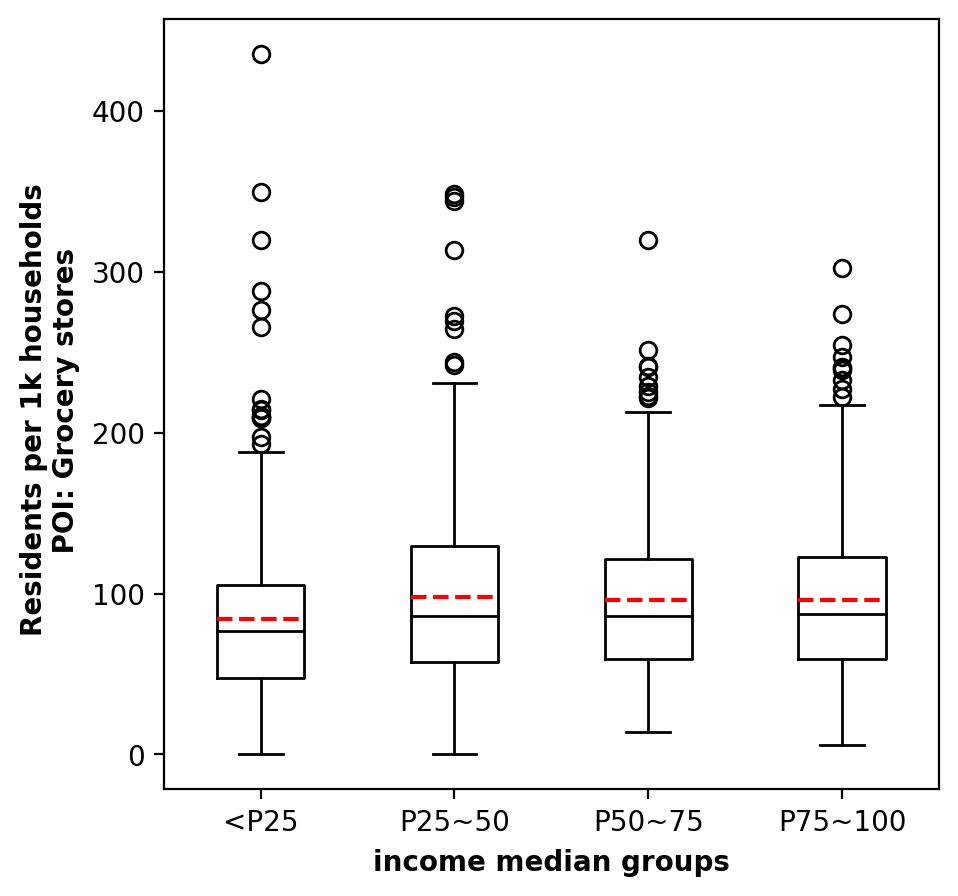

In [171]:
kw_test(df_08_23, 'income_median', False)

# Analysis based on PNAS paper methods

In [172]:
def Divide(dataframe):
    quantile1 = dataframe['income_median'].quantile(0.25)
    quantile2 = dataframe['income_median'].quantile(0.5)
    quantile3 = dataframe['income_median'].quantile(0.75)
    quantile4 = dataframe['income_median'].quantile(1)

    group1 = dataframe[(dataframe['income_median'] >= 0) & (dataframe['income_median'] < quantile1)]
    group2 = dataframe[(dataframe['income_median'] >= quantile1) & (dataframe['income_median'] < quantile2)]
    group3 = dataframe[(dataframe['income_median'] >= quantile2) & (dataframe['income_median'] < quantile3)]
    group4 = dataframe[(dataframe['income_median'] >= quantile3) & (dataframe['income_median'] <= quantile4)]
    
    return group1, group2, group3, group4

In [173]:
def Reg(dataframe):
    g_1, g_2, g_3, g_4 = Divide(dataframe)
    
    formula = ('visits_per_household ~ white_per_population') #rainfall_transfer remove this indepent variable
    
    model1 = sm.ols(formula = formula, data = g_1)
    result1 = model1.fit()
    print('Data sournce: P<25')
    print(result1.summary())
    print('\n')
    
    model2 = sm.ols(formula = formula, data = g_2)
    result2 = model2.fit()
    print('Data sournce: P25~50')
    print(result2.summary())
    print('\n')
    
    model3 = sm.ols(formula = formula, data = g_3)
    result3 = model3.fit()
    print('Data sournce: P50~75')
    print(result3.summary())
    print('\n')
    
    model4 = sm.ols(formula = formula, data = g_4)
    result4 = model4.fit()
    print('Data sournce: P75~100')
    print(result4.summary())
    print('\n')
    
    return None

In [174]:
df_income_race = Cor_analysis(grocery_new_08_23, de_0823)
df_income_race['white_per_population'] = df_income_race.White/df_income_race.Population

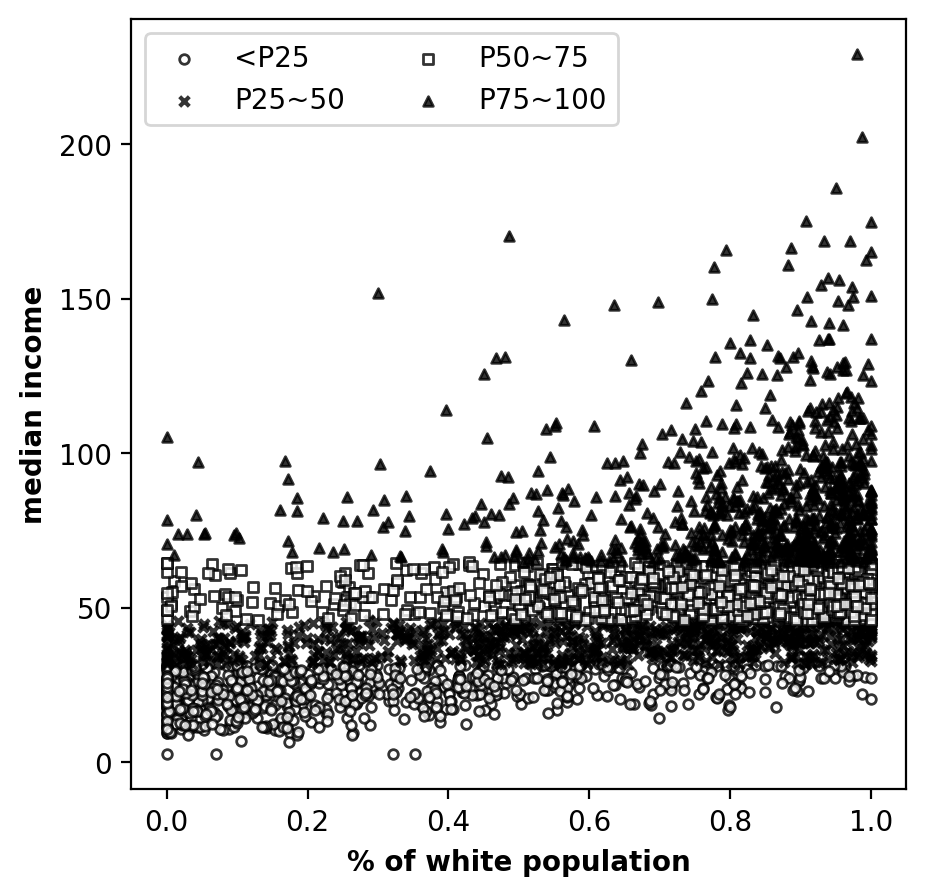

In [268]:
quantile1 = df_income_race['income_median'].quantile(0.25)
quantile2 = df_income_race['income_median'].quantile(0.5)
quantile3 = df_income_race['income_median'].quantile(0.75)
quantile4 = df_income_race['income_median'].quantile(1)

group1 = df_income_race[(df_income_race['income_median'] >= 0) & (df_income_race['income_median'] < quantile1)]
group2 = df_income_race[(df_income_race['income_median'] >= quantile1) & (df_income_race['income_median'] < quantile2)]
group3 = df_income_race[(df_income_race['income_median'] >= quantile2) & (df_income_race['income_median'] < quantile3)]
group4 = df_income_race[(df_income_race['income_median'] >= quantile3) & (df_income_race['income_median'] <= quantile4)]

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default') 
plt.rcParams.update({'figure.dpi':150})



plt.scatter(group1.white_per_population, group1.income_median/1000, 
            c='w', marker='o', alpha=0.8, s=12.0, label='<P25', edgecolors='black')
plt.scatter(group2.white_per_population, group2.income_median/1000, 
            c='black', marker='x', alpha=0.8, s=12.0, label='P25~50')
plt.scatter(group3.white_per_population, group3.income_median/1000, 
            c='w', marker='s', alpha=0.8, s=12.0, label='P50~75',edgecolors='black')
plt.scatter(group4.white_per_population, group4.income_median/1000, 
            c='black', marker='^', alpha=0.8, s=12.0, label='P75~100')

plt.legend(loc=2, ncol=2)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel( '% of white population', weight='bold')
plt.ylabel("median income", weight='bold')
plt.show()

In [176]:
spearmanr(df_income_race.white_per_population, df_income_race.income_median)

SpearmanrResult(correlation=0.596059657916263, pvalue=3.52899605455301e-309)

In [177]:
group1.white_per_population.median()

0.1852216748768473

In [178]:
group4.white_per_population.median()

0.8689731143060823

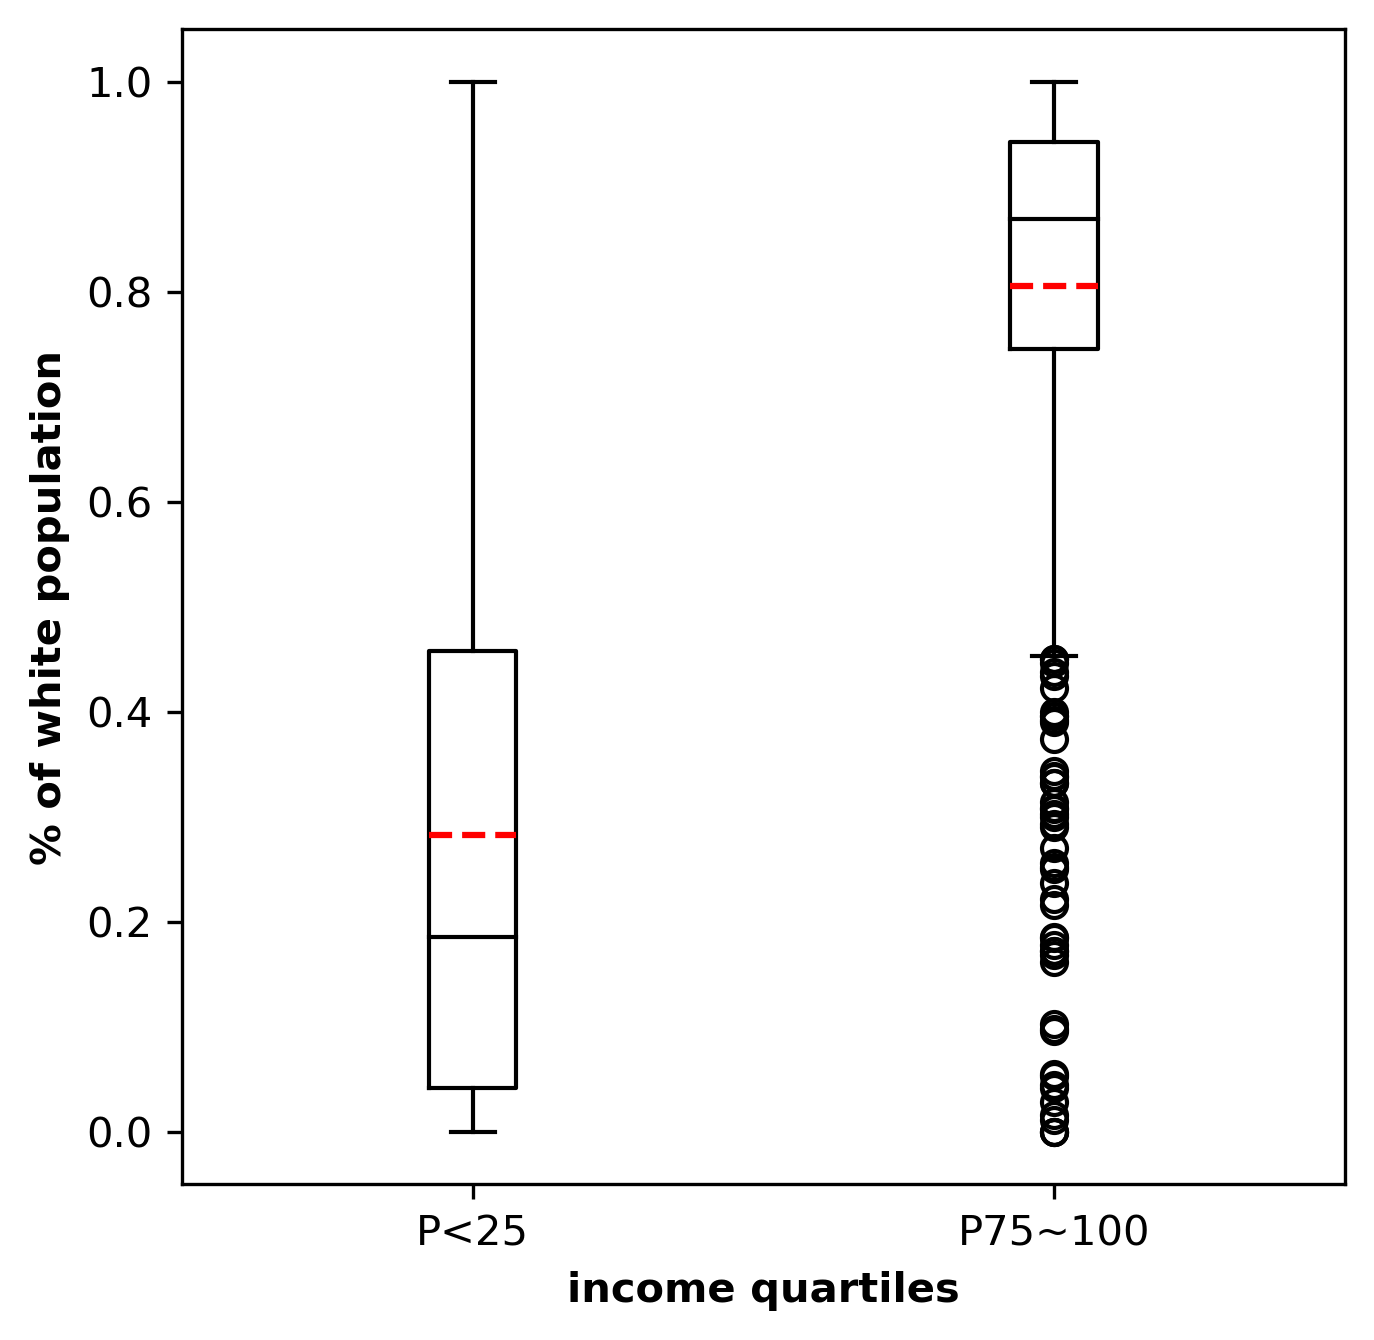

In [179]:
df_temp =  pd.concat(
        [
            group1.white_per_population.reset_index(drop=True).rename('P<25'),
            group4.white_per_population.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')
plt.rcParams.update({'figure.dpi':150})

color = {
"boxes": "Black",
"whiskers": "Black",
"medians": "Black",
"caps": "Black"}

meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)


plt.xlabel('income quartiles', weight='bold')
plt.ylabel("% of white population", weight='bold')
plt.show()

# if we use filtered data

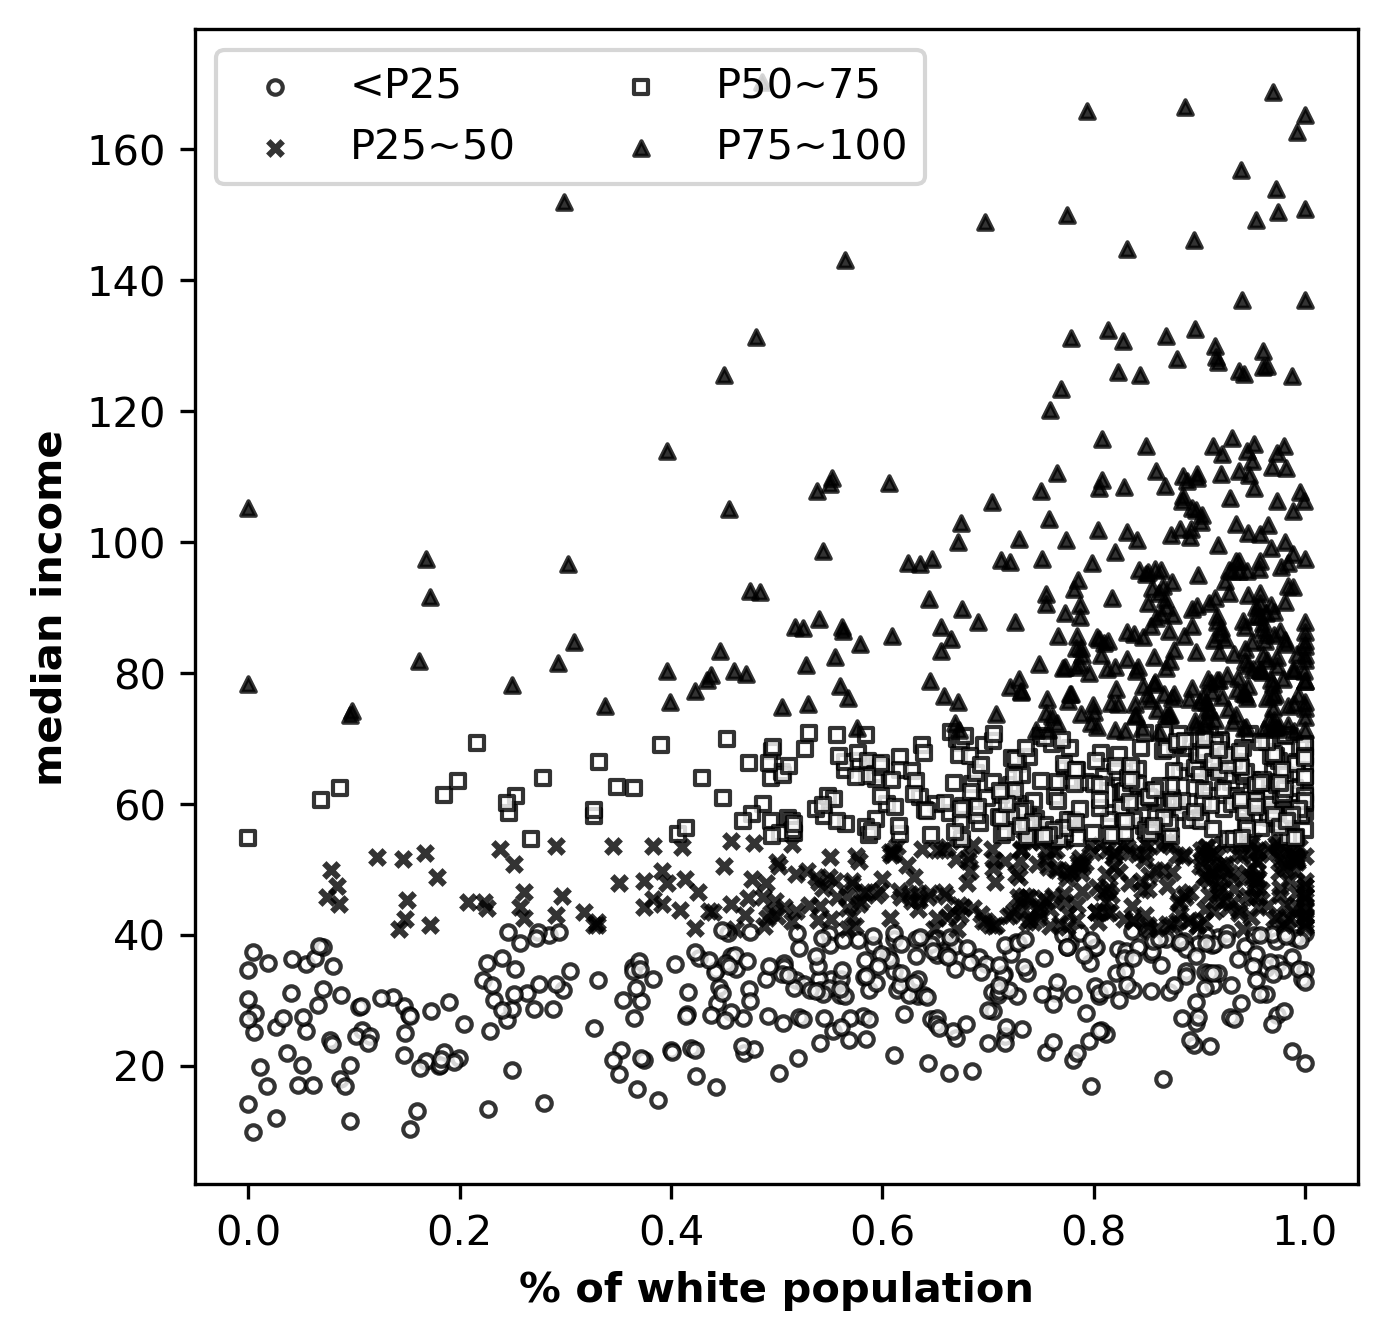

In [269]:
quantile1 = df_before['income_median'].quantile(0.25)
quantile2 = df_before['income_median'].quantile(0.5)
quantile3 = df_before['income_median'].quantile(0.75)
quantile4 = df_before['income_median'].quantile(1)

group1 = df_before[(df_before['income_median'] >= 0) & (df_before['income_median'] < quantile1)]
group2 = df_before[(df_before['income_median'] >= quantile1) & (df_before['income_median'] < quantile2)]
group3 = df_before[(df_before['income_median'] >= quantile2) & (df_before['income_median'] < quantile3)]
group4 = df_before[(df_before['income_median'] >= quantile3) & (df_before['income_median'] <= quantile4)]

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default') 
plt.rcParams.update({'figure.dpi':150})



plt.scatter(group1.white_per_population, group1.income_median/1000, 
            c='w', marker='o', alpha=0.8, s=12.0, label='<P25', edgecolors='black')
plt.scatter(group2.white_per_population, group2.income_median/1000, 
            c='black', marker='x', alpha=0.8, s=12.0, label='P25~50')
plt.scatter(group3.white_per_population, group3.income_median/1000, 
            c='w', marker='s', alpha=0.8, s=12.0, label='P50~75',edgecolors='black')
plt.scatter(group4.white_per_population, group4.income_median/1000, 
            c='black', marker='^', alpha=0.8, s=12.0, label='P75~100')

plt.legend(loc=2, ncol=2)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel( '% of white population', weight='bold')
plt.ylabel("median income", weight='bold')
plt.show()

In [181]:
spearmanr(df_before.white_per_population, df_before.income_median)

SpearmanrResult(correlation=0.3850747736992201, pvalue=2.9405674618749498e-55)

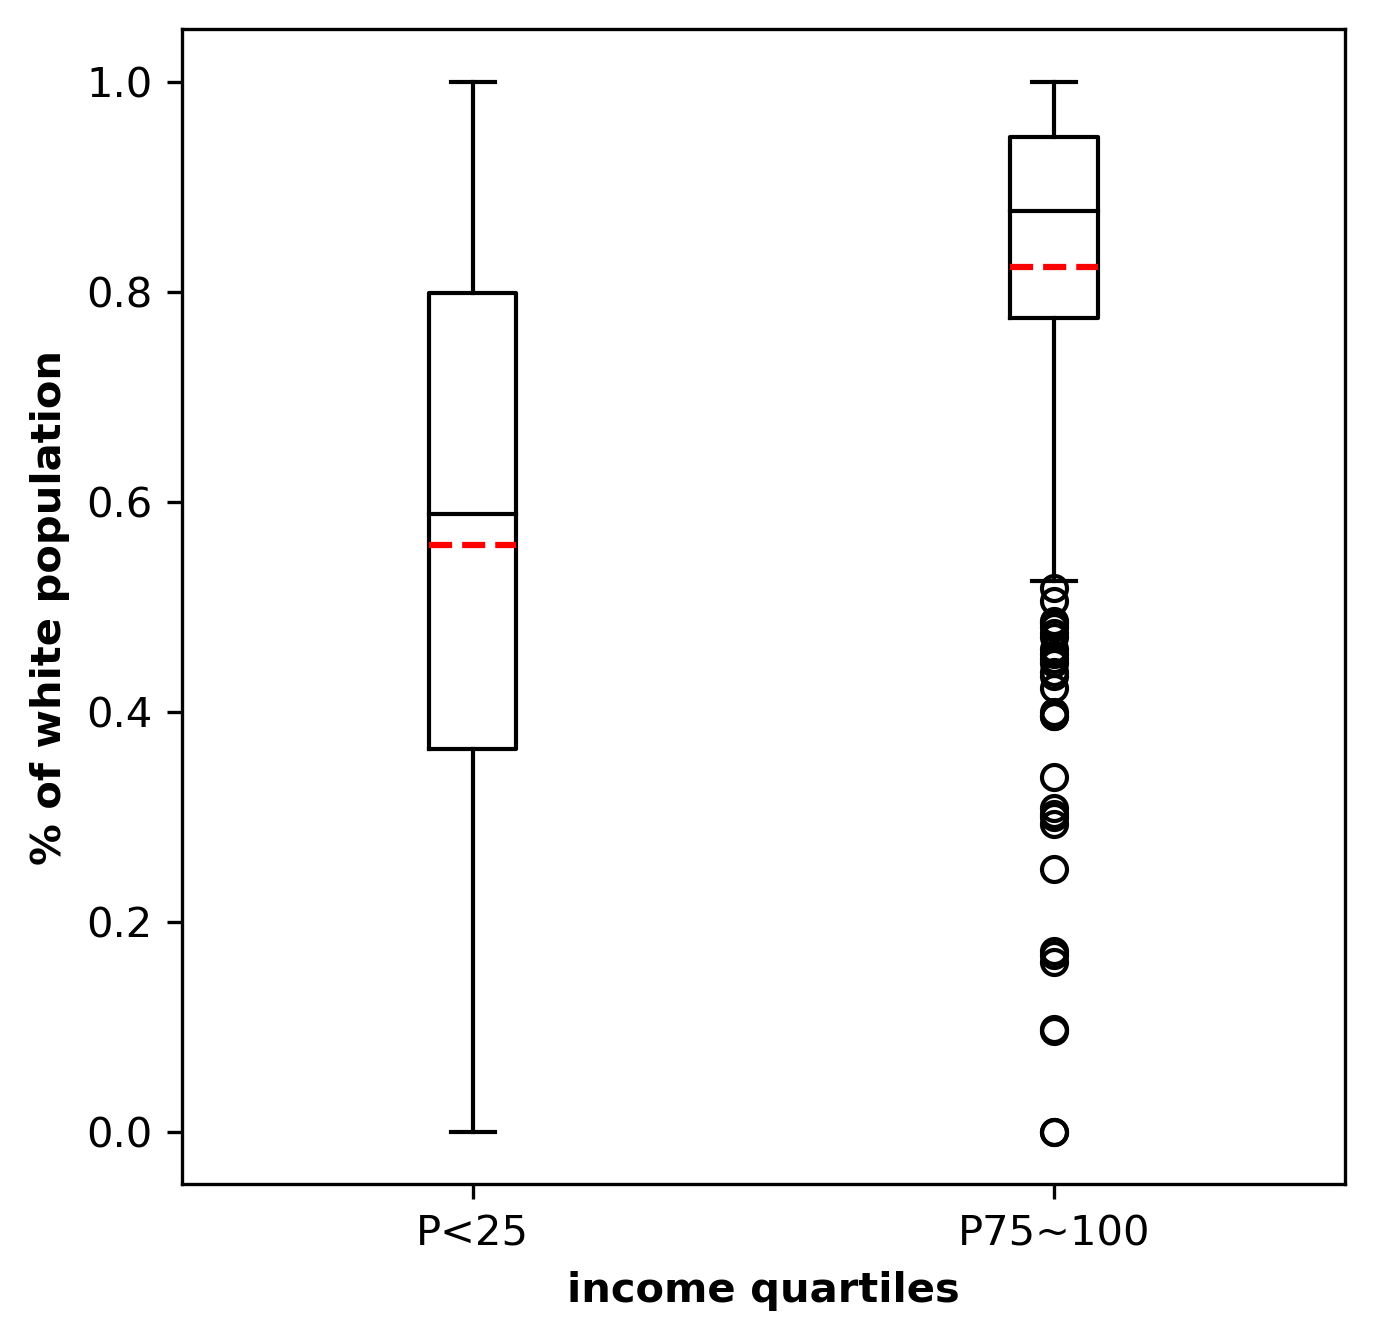

In [182]:
df_temp =  pd.concat(
        [
            group1.white_per_population.reset_index(drop=True).rename('P<25'),
            group4.white_per_population.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)

fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')
plt.rcParams.update({'figure.dpi':150})

color = {
"boxes": "Black",
"whiskers": "Black",
"medians": "Black",
"caps": "Black"}

meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)


plt.xlabel('income quartiles', weight='bold')
plt.ylabel("% of white population", weight='bold')
plt.show()

In [265]:
x = group1.white_per_population
print(x.median())

0.5878220140515222


In [266]:
y = group4.white_per_population
print(y.median())

0.8764900662251656


In [267]:
test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
print(test_result)

MannwhitneyuResult(statistic=31950.5, pvalue=1.215393253629924e-41)


# Results of regression in income strata

In [185]:
Reg(df_before)

Data sournce: P<25
                             OLS Regression Results                             
Dep. Variable:     visits_per_household   R-squared:                       0.155
Model:                              OLS   Adj. R-squared:                  0.153
Method:                   Least Squares   F-statistic:                     70.05
Date:                  Tue, 26 Jul 2022   Prob (F-statistic):           1.11e-15
Time:                          14:06:32   Log-Likelihood:                -1990.3
No. Observations:                   383   AIC:                             3985.
Df Residuals:                       381   BIC:                             3992.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [186]:
Reg(df_08_23)

Data sournce: P<25
                             OLS Regression Results                             
Dep. Variable:     visits_per_household   R-squared:                       0.149
Model:                              OLS   Adj. R-squared:                  0.146
Method:                   Least Squares   F-statistic:                     66.53
Date:                  Tue, 26 Jul 2022   Prob (F-statistic):           5.05e-15
Time:                          14:06:33   Log-Likelihood:                -2043.0
No. Observations:                   383   AIC:                             4090.
Df Residuals:                       381   BIC:                             4098.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

# p20 and p80 disparate ratio analysis

## income

In [247]:
def Divide_five(dataframe):
    quantile1 = dataframe['income_median'].quantile(0.25)
    quantile2 = dataframe['income_median'].quantile(0.5)
    quantile3 = dataframe['income_median'].quantile(0.75)
    quantile4 = dataframe['income_median'].quantile(1)
   

    group_25 = dataframe[(dataframe['income_median'] >= 0) & (dataframe['income_median'] < quantile1)]
    
    group_75 = dataframe[(dataframe['income_median'] >= quantile3) & (dataframe['income_median'] <= quantile4)]
    
    return group_25, group_75

In [188]:
P20_before, P80_before = Divide_five(df_before)

disparate_ratio_before = P80_before.visits_per_household.median()/P20_before.visits_per_household.median()

In [189]:
P20_before.income_median.median()

31910.0

In [190]:
P80_before.income_median.median()

86667.0

In [191]:
len(P20_before)

383

In [192]:
len(P80_before)

383

In [193]:
P20_before.visits_per_household.median()

69.3950177935943

In [194]:
P80_before.visits_per_household.median()

84.34959349593497

In [195]:
disparate_ratio_before

1.2154992703773193

In [196]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
stats.mannwhitneyu(x=P20_before['visits_per_household'], 
                   y=P80_before['visits_per_household'], 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=60006.0, pvalue=1.3247888584034792e-05)

In [197]:
P20_after, P80_after = Divide_five(df_08_23)

disparate_ratio_after= P80_after.visits_per_household.median()/P20_after.visits_per_household.median()

In [198]:
P80_after.visits_per_household.median()

87.0

In [199]:
P20_after.visits_per_household.median()

76.50273224043715

In [200]:
disparate_ratio_after

1.1372142857142857

In [201]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
stats.mannwhitneyu(x=P20_after['visits_per_household'], 
                   y=P80_after['visits_per_household'], 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=60784.5, pvalue=4.1007981374599697e-05)

## race

### Before Ida

In [202]:
P25_before, P50_before, P75_before, P100_before = Divide(df_before)

In [203]:
len(P25_before)

383

In [204]:
def Divide_race(dataframe):
    quantile1 = dataframe['white_per_population'].quantile(0.25)
    quantile2 = dataframe['white_per_population'].quantile(0.5)
    quantile3 = dataframe['white_per_population'].quantile(0.75)
    quantile4 = dataframe['white_per_population'].quantile(1.0)
    #quantile5 = dataframe['white_per_population'].quantile(1.0)

    group_25 = dataframe[(dataframe['white_per_population'] >= 0) & (dataframe['white_per_population'] < quantile1)]
    
    group_75 = dataframe[(dataframe['white_per_population'] >= quantile3) & (dataframe['white_per_population'] <= quantile4)]
    
    return group_25, group_75

In [205]:
def disparate_ratio_in_income_strata(income_strata):
    race_20, race_80 = Divide_race(income_strata)
    disparate_ratio = race_80.visits_per_household.median()/race_20.visits_per_household.median()
    median_20 = race_20.visits_per_household.median()
    median_80 = race_80.visits_per_household.median()
    
    print('median visits of p20 white is', median_20)
    print('median visits of p80 white is', median_80)
    print('p80/p20 disparate ratio is: ', disparate_ratio)
    
    x=race_20['visits_per_household']
    y=race_80['visits_per_household']
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    print('median percentage of p20 white is', race_20.white_per_population.median())
    print('median percentage of p80 white is', race_80.white_per_population.median())
    print(test_result)
    return None

In [206]:
disparate_ratio_in_income_strata(P25_before)

median visits of p20 white is 52.42537815926923
median visits of p80 white is 95.96569560337676
p80/p20 disparate ratio is:  1.830519854560348
median percentage of p20 white is 0.1526916090427562
median percentage of p80 white is 0.9059241666208189
MannwhitneyuResult(statistic=1738.0, pvalue=9.105336130021249e-14)


In [207]:
disparate_ratio_in_income_strata(P50_before)

median visits of p20 white is 62.488878720862246
median visits of p80 white is 114.14591791481146
p80/p20 disparate ratio is:  1.826659723319747
median percentage of p20 white is 0.47157871550394914
median percentage of p80 white is 0.9686661574239533
MannwhitneyuResult(statistic=1930.0, pvalue=3.536417374535234e-12)


In [208]:
disparate_ratio_in_income_strata(P75_before)

median visits of p20 white is 69.22994422994424
median visits of p80 white is 103.20349365456197
p80/p20 disparate ratio is:  1.4907348951744936
median percentage of p20 white is 0.555546782174495
median percentage of p80 white is 0.9706184816225056
MannwhitneyuResult(statistic=2549.0, pvalue=8.953704168319116e-08)


In [209]:
disparate_ratio_in_income_strata(P100_before)

median visits of p20 white is 67.69731055533387
median visits of p80 white is 87.77853440774788
p80/p20 disparate ratio is:  1.2966325203716946
median percentage of p20 white is 0.6170077133932556
median percentage of p80 white is 0.9733609114180966
MannwhitneyuResult(statistic=3314.0, pvalue=0.0007801258245331115)


### Preparation

In [309]:
a = (P100_after.number_devices_residing/P100_after.households)
print(a.median())
print(a.mean())

0.2109004739336493
0.2258635285828973


In [310]:
b = (P25_after.number_devices_residing/P25_after.households)
print(b.median())
print(b.mean())

0.17882352941176471
0.1989168715303345


In [311]:
test_result = stats.mannwhitneyu(a, b, alternative = 'two-sided')
print(test_result)

MannwhitneyuResult(statistic=93006.5, pvalue=1.3527419880393143e-10)


In [312]:
test_result = stats.ttest_ind(a, b, alternative = 'two-sided', equal_var=False)
print(test_result)

Ttest_indResult(statistic=4.003436565305979, pvalue=6.854228751931739e-05)


In [210]:
P25_after, P50_after, P75_after, P100_after = Divide(df_08_23)

In [211]:
disparate_ratio_in_income_strata(P25_after)

median visits of p20 white is 51.23351371370959
median visits of p80 white is 94.60533577141351
p80/p20 disparate ratio is:  1.8465517766371358
median percentage of p20 white is 0.1526916090427562
median percentage of p80 white is 0.9059241666208189
MannwhitneyuResult(statistic=1854.5, pvalue=8.634364521823167e-13)


In [212]:
disparate_ratio_in_income_strata(P50_after)

median visits of p20 white is 62.789888682745826
median visits of p80 white is 119.39497711569057
p80/p20 disparate ratio is:  1.9015000602875631
median percentage of p20 white is 0.47157871550394914
median percentage of p80 white is 0.9686661574239533
MannwhitneyuResult(statistic=2097.0, pvalue=6.993281518463247e-11)


In [213]:
disparate_ratio_in_income_strata(P75_after)

median visits of p20 white is 72.82177963048736
median visits of p80 white is 107.96199213630406
p80/p20 disparate ratio is:  1.4825508616258123
median percentage of p20 white is 0.555546782174495
median percentage of p80 white is 0.9706184816225056
MannwhitneyuResult(statistic=2560.5, pvalue=1.0554681397230974e-07)


In [214]:
disparate_ratio_in_income_strata(P100_after)

median visits of p20 white is 75.19026363957484
median visits of p80 white is 101.03361479001526
p80/p20 disparate ratio is:  1.3437060850633633
median percentage of p20 white is 0.6170077133932556
median percentage of p80 white is 0.9733609114180966
MannwhitneyuResult(statistic=3342.0, pvalue=0.0010125167613379052)


# now we use ratio instead of difference

## income p75/p25

In [248]:
def Divide_five2(dataframe):
    quantile1 = dataframe['income_median'].quantile(0.25)
    quantile2 = dataframe['income_median'].quantile(0.5)
    quantile3 = dataframe['income_median'].quantile(0.75)
    quantile4 = dataframe['income_median'].quantile(1)
   

    group_25 = dataframe[(dataframe['income_median'] > quantile1) & (dataframe['income_median'] < quantile2)]
    
    group_75 = dataframe[(dataframe['income_median'] >= quantile2) & (dataframe['income_median'] < quantile3)]
    
    return group_25, group_75

In [259]:
def disparate_ratio_in_income(dataframe):
    temp_20, temp_80 = Divide_five2(dataframe)
    
    print('number cbgs in P25 income', len(temp_20))
    print('number cbgs in P75 income', len(temp_80))
    
    income_20 = temp_20.replace([np.inf, -np.inf], np.nan)
    income_80 = temp_80.replace([np.inf, -np.inf], np.nan)
    
    disparate_ratio = income_80.ratio.dropna().median()/income_20.dropna().ratio.median()
    median_20 = income_20.ratio.dropna().median()
    median_80 = income_80.ratio.dropna().median()
    
    print('median ratio of p25 income is', median_20)
    print('median ratio of p75 income is', median_80)
    print('p75/p25 disparate ratio is: ', disparate_ratio)
    
    x=income_20['ratio'].dropna()
    y=income_80['ratio'].dropna()
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    
    print('median income of p25 income is', income_20.income_median.median())
    print('median income of p75 income is', income_80.income_median.median())
    print(test_result)
    return None

In [260]:
disparate_ratio_in_income(df_ratio)

number cbgs in P25 income 382
number cbgs in P75 income 382
median ratio of p25 income is 1.0340273761326393
median ratio of p75 income is 1.0585392708588206
p75/p25 disparate ratio is:  1.0237052666998607
median income of p25 income is 47290.0
median income of p75 income is 62040.5
MannwhitneyuResult(statistic=68957.0, pvalue=0.18920260258287924)


## race

### Ratio as preparation

In [217]:
P25_ratio, P50_ratio, P75_ratio, P100_ratio = Divide(df_ratio)

In [218]:
def Divide_race(dataframe):
    quantile1 = dataframe['white_per_population'].quantile(0.25)
    quantile2 = dataframe['white_per_population'].quantile(0.5)
    quantile3 = dataframe['white_per_population'].quantile(0.75)
    quantile4 = dataframe['white_per_population'].quantile(1.0)
  

    group_25 = dataframe[(dataframe['white_per_population'] >= 0) & (dataframe['white_per_population'] < quantile1)]
    
    group_75 = dataframe[(dataframe['white_per_population'] >= quantile3) & (dataframe['white_per_population'] <= quantile4)]
    
    return group_25, group_75

In [219]:
def disparate_ratio_in_income_strata(income_strata):
    
    race_20, race_80 = Divide_race(income_strata)
    
    #race_20 = temp_20.replace([np.inf, -np.inf], np.nan).dropna()
    #race_80 = temp_80.replace([np.inf, -np.inf], np.nan).dropna()
    
    #remove_outlier_20 = race_20.ratio[race_20.ratio.between(race_20.ratio.quantile(.01), 
                                                            #race_20.ratio.quantile(.99))]
    #remove_outlier_80 = race_80.ratio[race_80.ratio.between(race_80.ratio.quantile(.01), 
                                                            #race_80.ratio.quantile(.99))]
    
    disparate_ratio = race_80.ratio.median()/race_20.ratio.median()
    median_20 = race_20.ratio.median()
    median_80 = race_80.ratio.median()
    
    print('median ratio in p25 white is', median_20)
    print('median ratio in p75 white is', median_80)
    print('p75/p25 disparate ratio is: ', disparate_ratio)
    
    x=race_20.ratio.dropna()
    y=race_80.ratio.dropna()
    test_result = stats.mannwhitneyu(x, y, alternative = 'two-sided')
    
    #print('test p20 ratio and 1')
    #test_result1 = stats.mannwhitneyu(x, 1, alternative = 'greater')
    #print(test_result1)
    
    #print('test p80 ratio and 1')
    #test_result2 = stats.mannwhitneyu(y, 1, alternative = 'greater')
    #print(test_result2)
    
    print('median percentage of p25 white is', race_20.white_per_population.median())
    print('median percentage of p75 white is', race_80.white_per_population.median())
    print(test_result)
    return None

In [220]:
disparate_ratio_in_income_strata(P25_ratio)

median ratio in p25 white is 0.9300813008130082
median ratio in p75 white is 1.0405073649754502
p75/p25 disparate ratio is:  1.1187273242305975
median percentage of p25 white is 0.1526916090427562
median percentage of p75 white is 0.9059241666208189
MannwhitneyuResult(statistic=3792.0, pvalue=0.03415747136943244)


In [221]:
disparate_ratio_in_income_strata(P50_ratio)

median ratio in p25 white is 1.0108108108108107
median ratio in p75 white is 1.044994944388271
p75/p25 disparate ratio is:  1.0338185278707495
median percentage of p25 white is 0.47157871550394914
median percentage of p75 white is 0.9686661574239533
MannwhitneyuResult(statistic=4500.0, pvalue=0.7800733129181382)


In [222]:
disparate_ratio_in_income_strata(P75_ratio)

median ratio in p25 white is 1.0113532217338446
median ratio in p75 white is 1.0454077126876657
p75/p25 disparate ratio is:  1.0336722029672667
median percentage of p25 white is 0.555546782174495
median percentage of p75 white is 0.9706184816225056
MannwhitneyuResult(statistic=4304.0, pvalue=0.4305118804198571)


In [223]:
disparate_ratio_in_income_strata(P100_ratio)

median ratio in p25 white is 1.068575624082232
median ratio in p75 white is 1.0635515482369786
p75/p25 disparate ratio is:  0.9952983432037688
median percentage of p25 white is 0.6170077133932556
median percentage of p75 white is 0.9733609114180966
MannwhitneyuResult(statistic=4562.0, pvalue=0.9059228831990123)


## regression ratio

In [278]:
df_before

,GEOID,visits,Population,White,Black,income_median,households,number_devices_residing,white_per_population,visits_per_population,visits_per_household
0,221090012021,35.666667,950,858,9,52361.0,305,77.000000,0.903158,37.543860,116.939891
1,221090012023,52.666667,950,822,0,49904.0,346,88.666667,0.865263,55.438596,152.215800
2,221030413003,21.666667,1568,1420,148,72083.0,769,83.000000,0.905612,13.818027,28.175119
3,221030407011,113.666667,2946,2715,109,53894.0,1176,238.333333,0.921589,38.583390,96.655329
4,221030411011,52.666667,3721,2987,642,71655.0,1251,212.333333,0.802741,14.153901,42.099654
...,...,...,...,...,...,...,...,...,...,...,...
3464,220070502002,151.666667,1223,1223,0,32833.0,604,138.333333,1.000000,124.011992,251.103753
3466,220070506003,84.000000,1937,1727,62,23867.0,630,130.666667,0.891585,43.366030,133.333333
3467,220070501002,64.666667,1877,916,943,41375.0,770,98.333333,0.488013,34.452140,83.982684
3468,220070503001,77.333333,1406,765,641,59848.0,554,79.666667,0.544097,55.002371,139.590854


In [224]:
def Reg_ratio(dataframe):
    #dataframe['rainfall_transfer'] = StandardScaler().fit_transform(dataframe[['rainfall_history']])
    temp = dataframe.replace([np.inf, -np.inf], np.nan)
    index = temp[temp.ratio == 15].index
    temp = temp.drop(index)
    g_1, g_2, g_3, g_4 = Divide(temp.dropna())
    
    formula = ('ratio ~ white_per_population')# rainfall_transfer remove this variable
    
    model1 = sm.ols(formula = formula, data = g_1)
    result1 = model1.fit()
    print('Data sournce: P<25')
    print(result1.summary())
    print('\n')
    
    model2 = sm.ols(formula = formula, data = g_2)
    result2 = model2.fit()
    print('Data sournce: P25~50')
    print(result2.summary())
    print('\n')
    
    model3 = sm.ols(formula = formula, data = g_3)
    result3 = model3.fit()
    print('Data sournce: P50~75')
    print(result3.summary())
    print('\n')
    
    model4 = sm.ols(formula = formula, data = g_4)
    result4 = model4.fit()
    print('Data sournce: P75~100')
    print(result4.summary())
    print('\n')
    
    return None

In [225]:
Reg_ratio(df_ratio)

Data sournce: P<25
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.122
Date:                Tue, 26 Jul 2022   Prob (F-statistic):              0.290
Time:                        14:08:34   Log-Likelihood:                -257.26
No. Observations:                 383   AIC:                             518.5
Df Residuals:                     381   BIC:                             526.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept    

# 1

In [276]:
from scipy import stats
import scikit_posthocs as sp
def kw_test_ratio(dataframe, column, print_statistics=True):
    
    test_variable = 'ratio'
    
    #dataframe = dataframe.replace([np.inf, -np.inf], np.nan).dropna()
    
    quantile1 = dataframe[column].quantile(0.25)
    quantile2 = dataframe[column].quantile(0.5)
    quantile3 = dataframe[column].quantile(0.75)
    quantile4 = dataframe[column].quantile(1)
    
    group1 = dataframe[(dataframe[column] >= 0) & (dataframe[column] < quantile1)]
    group2 = dataframe[(dataframe[column] >= quantile1) & (dataframe[column] < quantile2)]
    group3 = dataframe[(dataframe[column] >= quantile2) & (dataframe[column] < quantile3)]
    group4 = dataframe[(dataframe[column] >= quantile3) & (dataframe[column] <= quantile4)]
    
    table = [['N', 'Min', 'Max', 'Median', 'Variance'], 
             ['Group 1', len(group1), group1[column].min(), group1[column].max(), group1[column].median(), group1[column].var()],
             ['Group 2', len(group2), group2[column].min(), group2[column].max(), group2[column].median(), group2[column].var()],
             ['Group 3', len(group3), group3[column].min(), group3[column].max(), group3[column].median(), group3[column].var()],
             ['Group 4', len(group4), group4[column].min(), group4[column].max(), group4[column].median(), group4[column].var()]]
    
    print('check the number of each group samples:')
    print(len(group1), len(group2), len(group3), len(group4))
    
    print('\n')
    
    #remove outlier
    
    test1 = group2[test_variable]
    test1 = test1[test1.between(test1.quantile(.01), test1.quantile(.99))]
    
    test2 = group1[test_variable]
    test2 = test2[test2.between(test2.quantile(.01), test2.quantile(.99))]
    
    test3 = group3[test_variable]
    test3 = test3[test3.between(test3.quantile(.01), test3.quantile(.99))]
    
    test4 = group4[test_variable]
    test4 = test4[test4.between(test4.quantile(.01), test4.quantile(.99))]
    
    
    print('median of each quantile')
    print(round(test1.median(),3), 
          round(test2.median(),3), 
          round(test3.median(),3), 
          round(test4.median(),3))
    
    print('\n')
    
    print('Results of KW test')
    kw = stats.kruskal( test1, test3)
    print(kw)
    
    print('\n')
    
    print('Results of Dunn test')
    dunn = sp.posthoc_dunn([test1,test2,test3,test4],
                           p_adjust = 'fdr_bh')
    print(dunn)
    
    print('\n')
    
    print('Boxplots of ratios of four groups')
    df_temp =  pd.concat(
        [
            test1.reset_index(drop=True).rename('<P25'),
            test2.reset_index(drop=True).rename('P25~50'),
            test3.reset_index(drop=True).rename('P50~75'),
            test4.reset_index(drop=True).rename('P75~100'),
        ], 
        axis=1)
    
    import matplotlib_inline.backend_inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
    
    fig, ax = plt.subplots(figsize = (5,5))
    plt.style.use('default')
    
    color = {
    "boxes": "Black",
    "whiskers": "Black",
    "medians": "Black",
    "caps": "Black"}
    
    meanlineprops = dict(linestyle='--', linewidth=1.5, color='Red')
    df_temp.boxplot(showfliers=True, grid=False, color=color, meanprops=meanlineprops, showmeans=True, meanline=True)
    
    plt.xlabel(column.replace('_', ' ') + ' groups', weight='bold')
    plt.ylabel("Ratio \n POI: Gasoline stations", weight='bold')
    plt.show()
    
    if print_statistics:
        print('Basic statistics of each group')
        print(tabulate(table, headers='firstrow', tablefmt='pretty'))

        print('Boxplots of four groups')
        df_temp1 =  pd.concat(
            [
                group1[column].reset_index(drop=True).rename('<P25'),
                group2[column].reset_index(drop=True).rename('P25~50'),
                group3[column].reset_index(drop=True).rename('P50~75'),
                group4[column].reset_index(drop=True).rename('P75~100'),
            ], 
            axis=1)
        fig, ax = plt.subplots(figsize = (5,5))
        plt.style.use('default')

        color = {
        "boxes": "Black",
        "whiskers": "Black",
        "medians": "Red",
        "caps": "Black"}

        df_temp1.boxplot(showfliers=False, grid=False, color=color)

        plt.ylabel(column.replace('_', ' '), weight='bold')
        plt.show()
    
    
    return None
    

check the number of each group samples:
383 382 382 383


median of each quantile
1.034 1.057 1.059 1.067


Results of KW test
KruskalResult(statistic=1.8266900332972333, pvalue=0.17651900304594698)


Results of Dunn test
          1         2         3         4
1  1.000000  0.765731  0.650245  0.650245
2  0.765731  1.000000  0.650245  0.738616
3  0.650245  0.650245  1.000000  0.765731
4  0.650245  0.738616  0.765731  1.000000


Boxplots of ratios of four groups


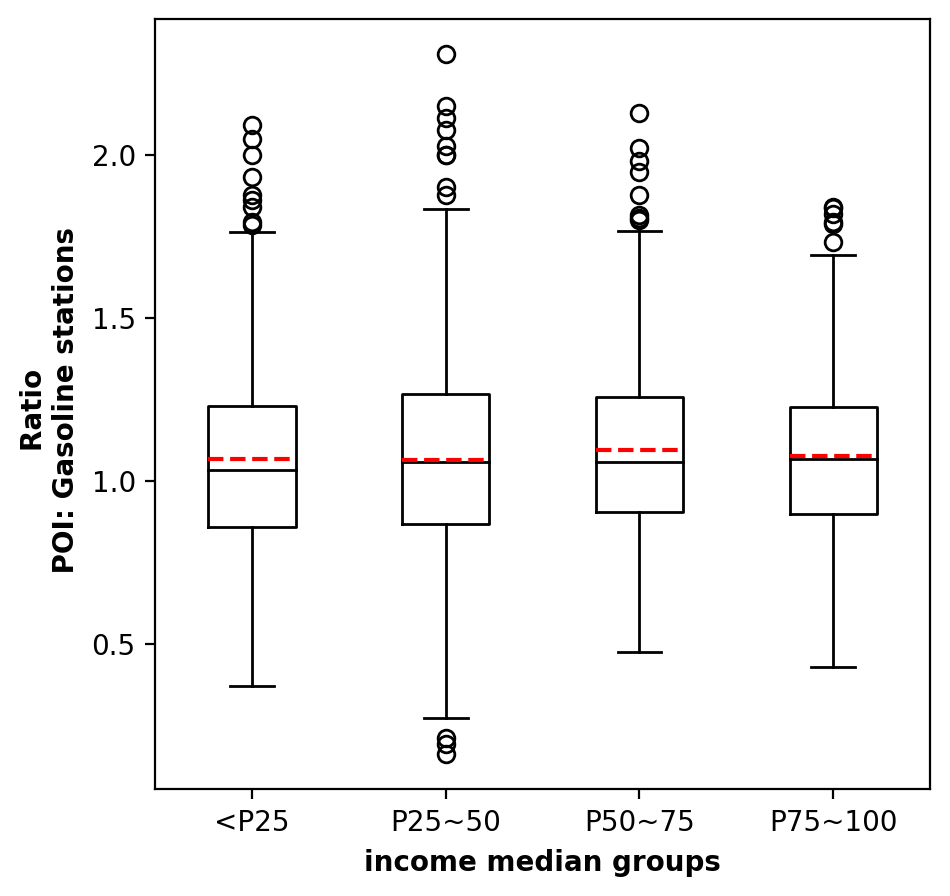

Basic statistics of each group
+---------+-----+---------+----------+---------+--------------------+
|         |  N  |   Min   |   Max    | Median  |      Variance      |
+---------+-----+---------+----------+---------+--------------------+
| Group 1 | 383 | 9910.0  | 40750.0  | 31910.0 | 46757931.65857859  |
| Group 2 | 382 | 40805.0 | 54464.0  | 47290.0 | 16894451.955201935 |
| Group 3 | 382 | 54554.0 | 70893.0  | 62040.5 | 21207877.27524014  |
| Group 4 | 383 | 70962.0 | 170278.0 | 86667.0 | 412770874.3385507  |
+---------+-----+---------+----------+---------+--------------------+
Boxplots of four groups


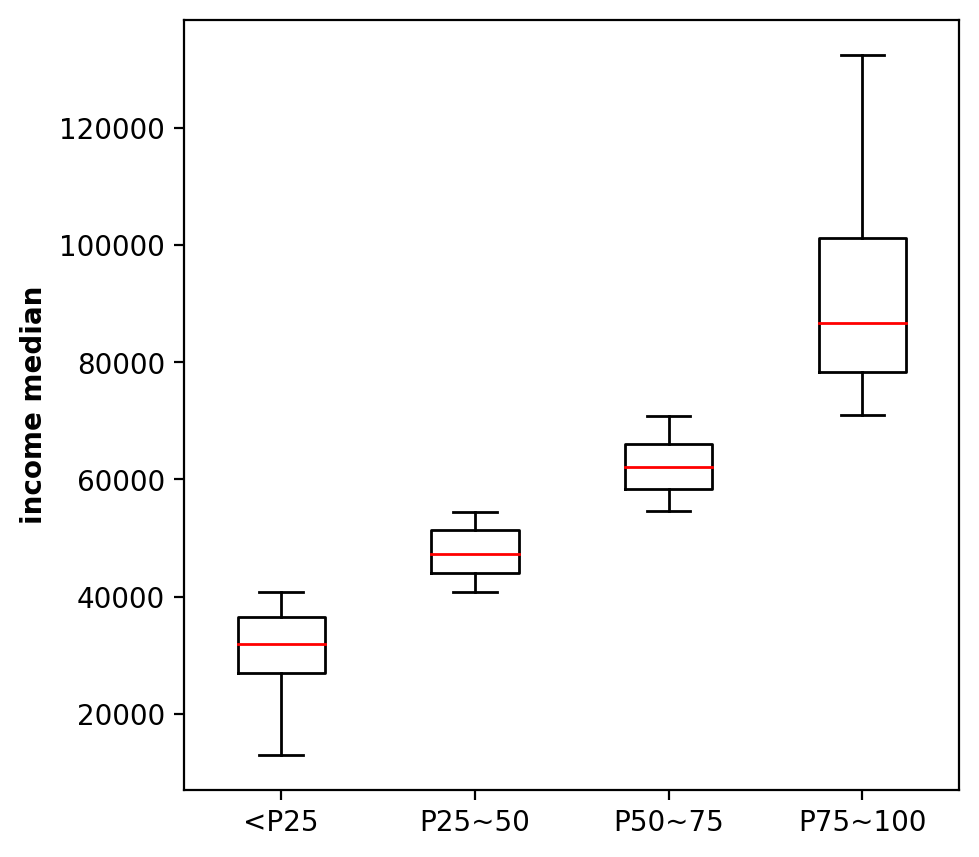

In [277]:
kw_test_ratio(df_ratio, 'income_median', print_statistics=True)

# number of device residing, population and number of households

In [228]:
from sklearn import linear_model

def Getline(xdata,ydata):
    X = np.array(xdata).reshape(-1,1)
    y = np.array(ydata).reshape(-1,1)
    reg_model = linear_model.LinearRegression()
    reg_model.fit(X,y)
    # Create the fited line
    a,b = reg_model.coef_, reg_model.intercept_
    index,amp = float(a),float(b)
    return [index,amp,reg_model.score(X,y)]

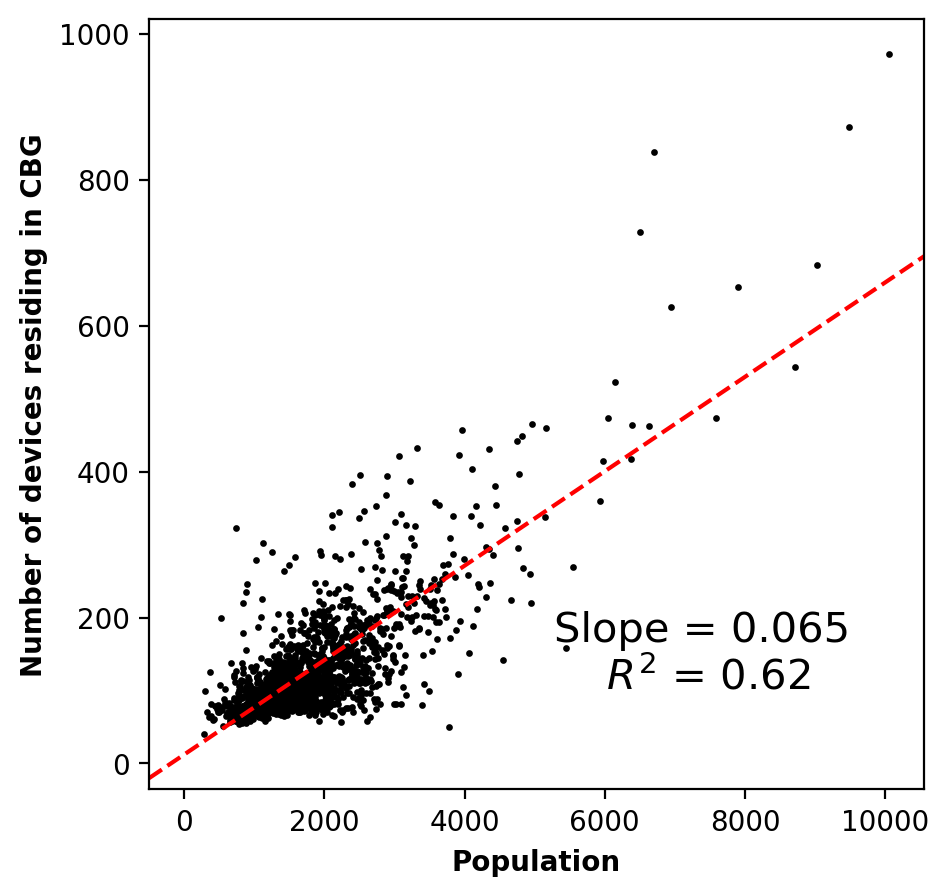

In [229]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.Population
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Population", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

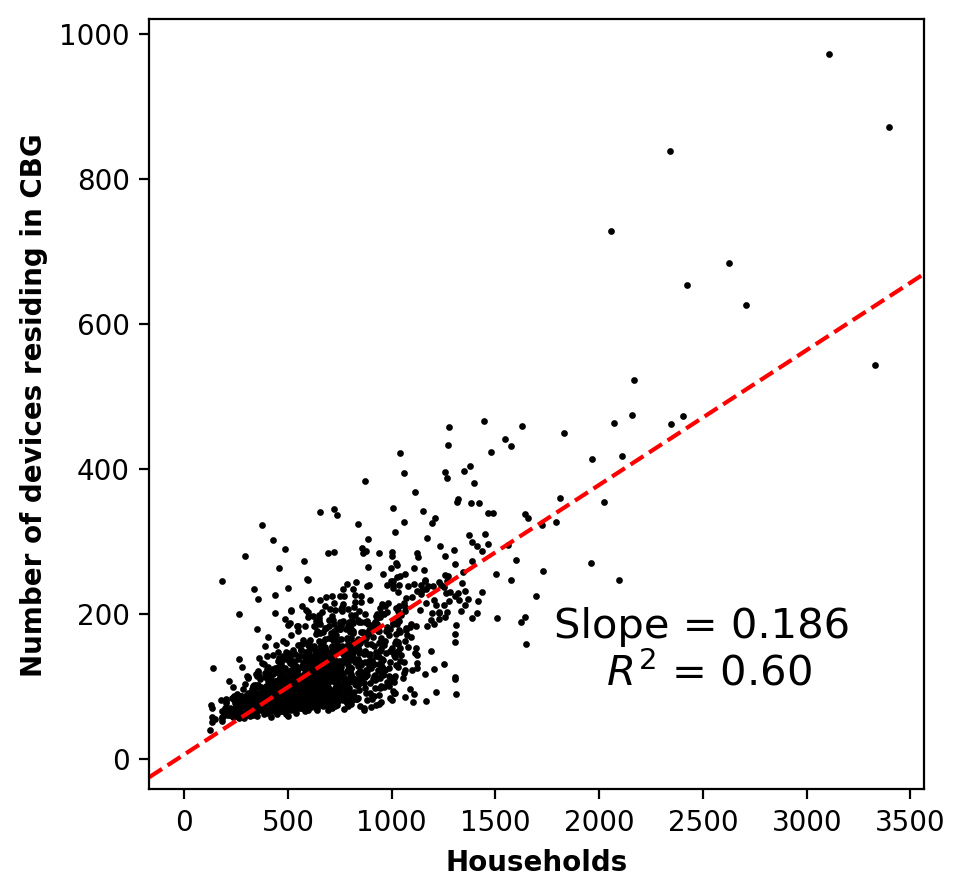

In [230]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.households
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Households", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

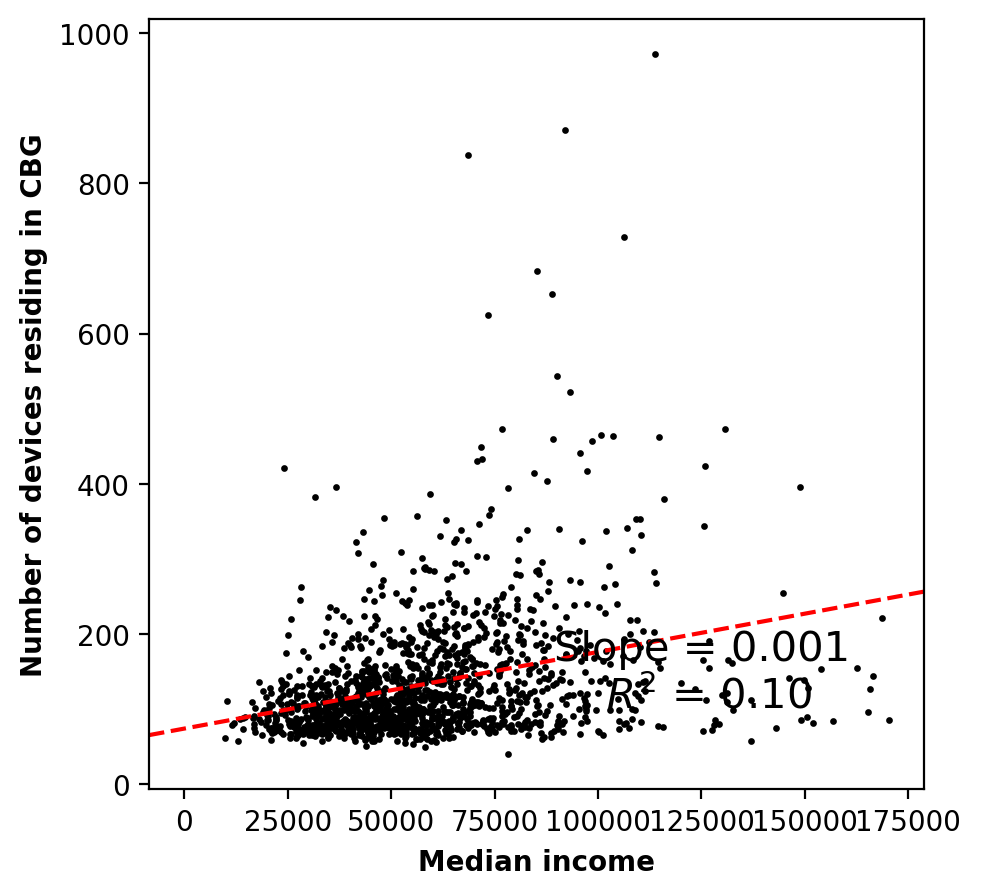

In [100]:
fig, ax = plt.subplots(figsize = (5,5))
plt.style.use('default')

x = df_before.income_median
y = df_before.number_devices_residing

slope, intercept, r = Getline(x, y)

plt.scatter(x, y, s=2, c='black', alpha=1)
plt.axline((0, intercept), slope=slope, ls='--', c='Red', alpha=1)

#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

axes = plt.gca()
#print(axes.get_xlim())
#print(axes.get_ylim())
plt.text(x = 0.5*axes.get_xlim()[1],y = 0.1*axes.get_ylim()[1],s = 'Slope = %.3f\n    $R^2$ = %.2f'%(slope,r),fontsize = 15)

plt.xlabel("Median income", weight='bold')
plt.ylabel("Number of devices residing in CBG", weight='bold')
#plt.title('Unique devices and total visits')
plt.show()

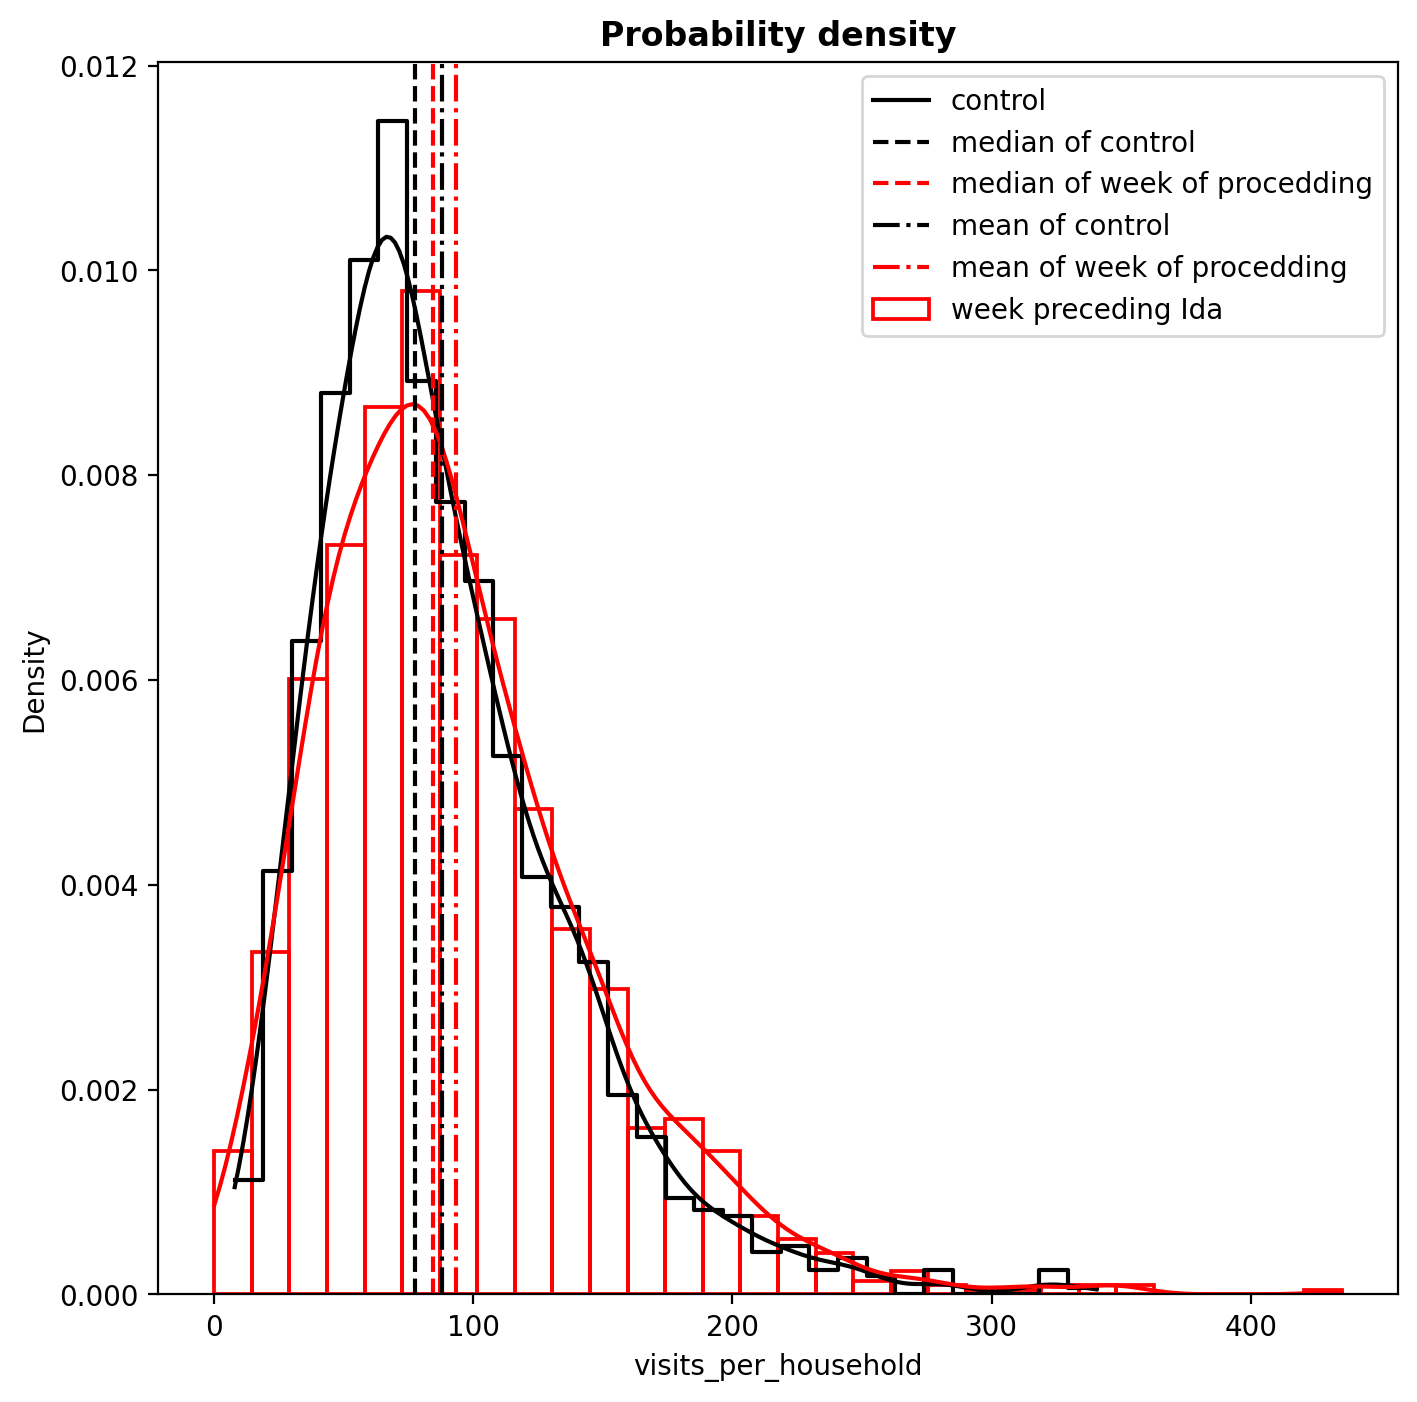

In [101]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8,8))
plt.style.use('default')

data1 = df_before.visits_per_household
median1 = data1.median()
mean1 = data1.mean()

data2 = df_08_23.visits_per_household
median2 = data2.median()
mean2 = data2.mean()

sns.histplot(data1, label='control',bins=30, kde=True, color="black",
             fill=False, stat='density', element='step')
sns.histplot(data2, label='week preceding Ida', bins=30, kde=True, color="red", 
             fill=False, stat='density', multiple='stack')

plt.axvline(x = median1, linestyle='--',color = 'black', label = 'median of control')
plt.axvline(x = median2, linestyle='--',color = 'red', label = 'median of week of procedding')

plt.axvline(x = mean1, linestyle='-.',color = 'black', label = 'mean of control')
plt.axvline(x = mean2, linestyle='-.',color = 'red', label = 'mean of week of procedding')

plt.legend()
plt.title('Probability density', weight='bold')

plt.show()